# **Flight Price Prediction**

Joe Lardie

April 2023

# **Imports**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle 
import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [7]:
train_data = pd.read_excel(r"C:\Users\davyd\Downloads\coding dojo\Data_Train.xlsx")
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [8]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [9]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [11]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [12]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [14]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

    
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


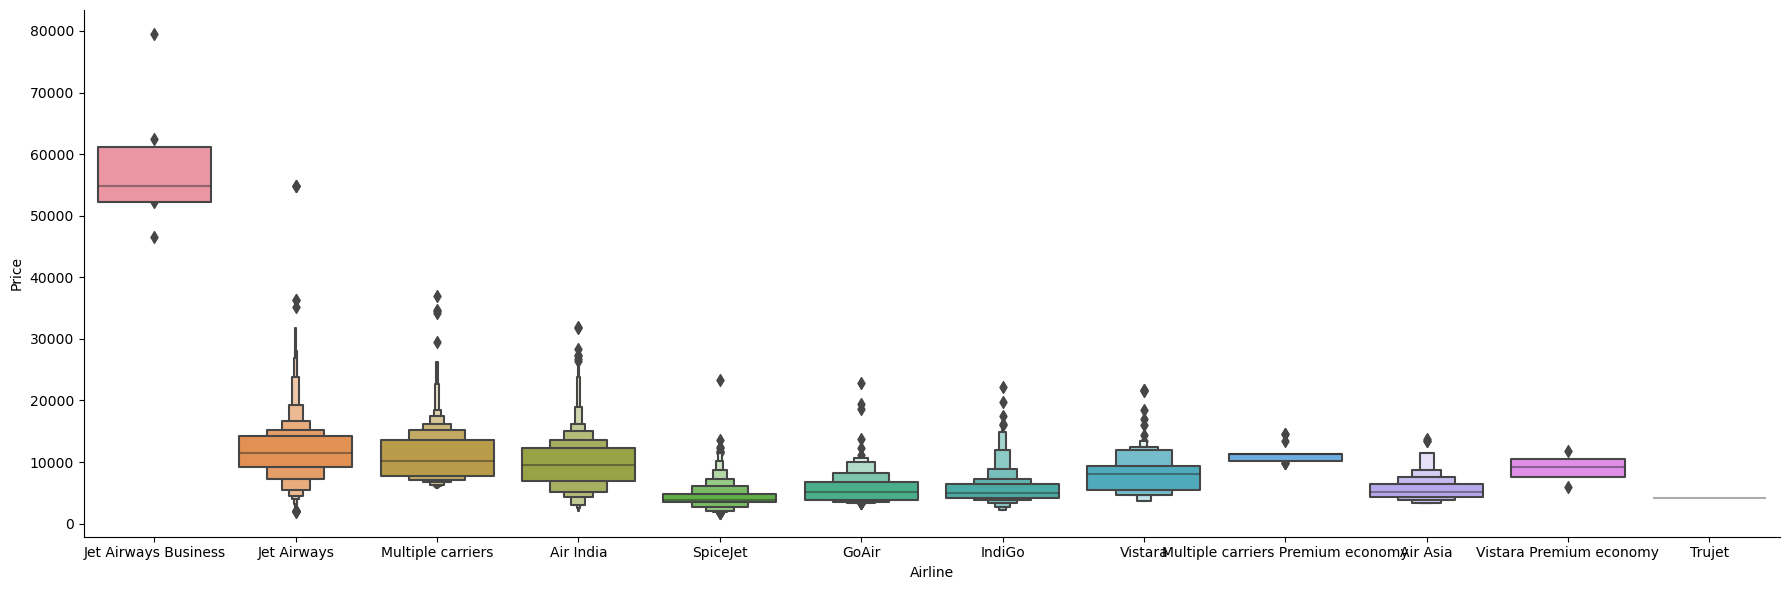

In [15]:
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [17]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

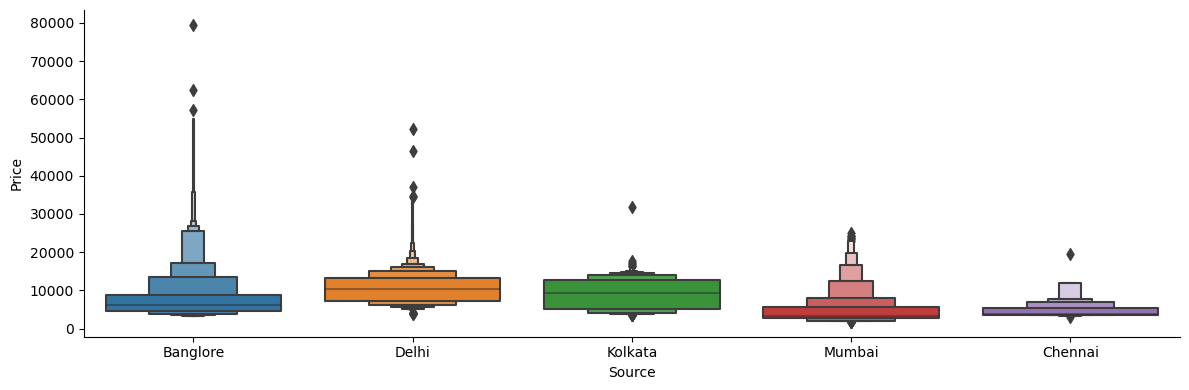

In [18]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [19]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


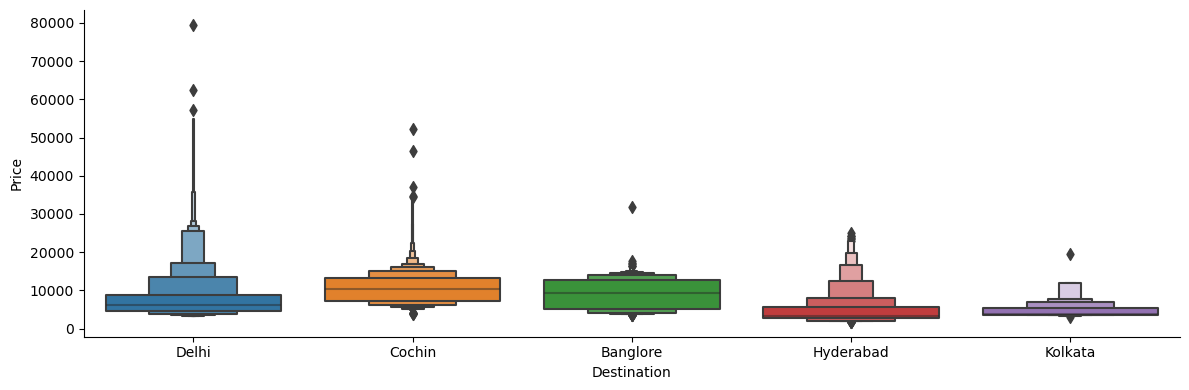

In [20]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [21]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [22]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [23]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [24]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [25]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


In [26]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


# **Feature Selection**

In [27]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [28]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

<AxesSubplot: >

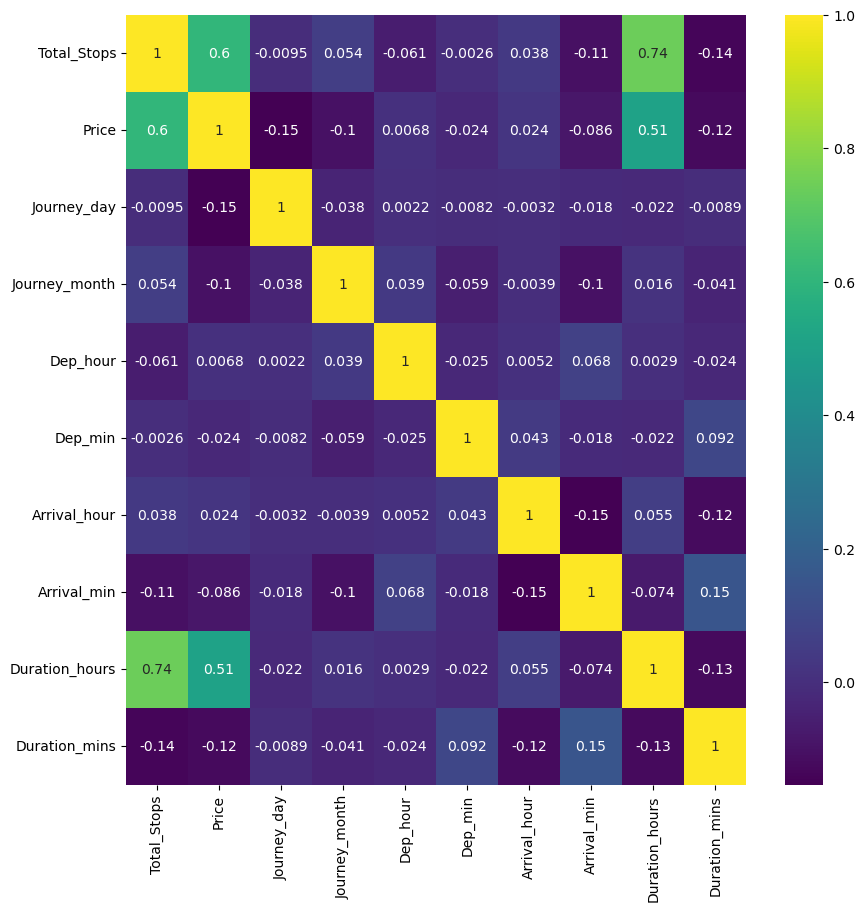

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

In [31]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.26599310e-01 1.43914990e-01 5.89907758e-02 2.38191489e-02
 2.15467441e-02 2.83660760e-02 1.86439098e-02 1.13247075e-01
 1.77339493e-02 1.06863759e-02 1.66389293e-03 1.85856075e-02
 1.47332303e-01 6.81288774e-02 1.97764127e-02 8.41780777e-04
 4.96056822e-03 1.18141301e-04 4.91564859e-03 6.98565520e-05
 6.88530944e-04 1.17978957e-02 4.58916613e-03 8.27851914e-03
 1.34400976e-02 2.08644923e-02 9.66799387e-03 7.31861209e-04]


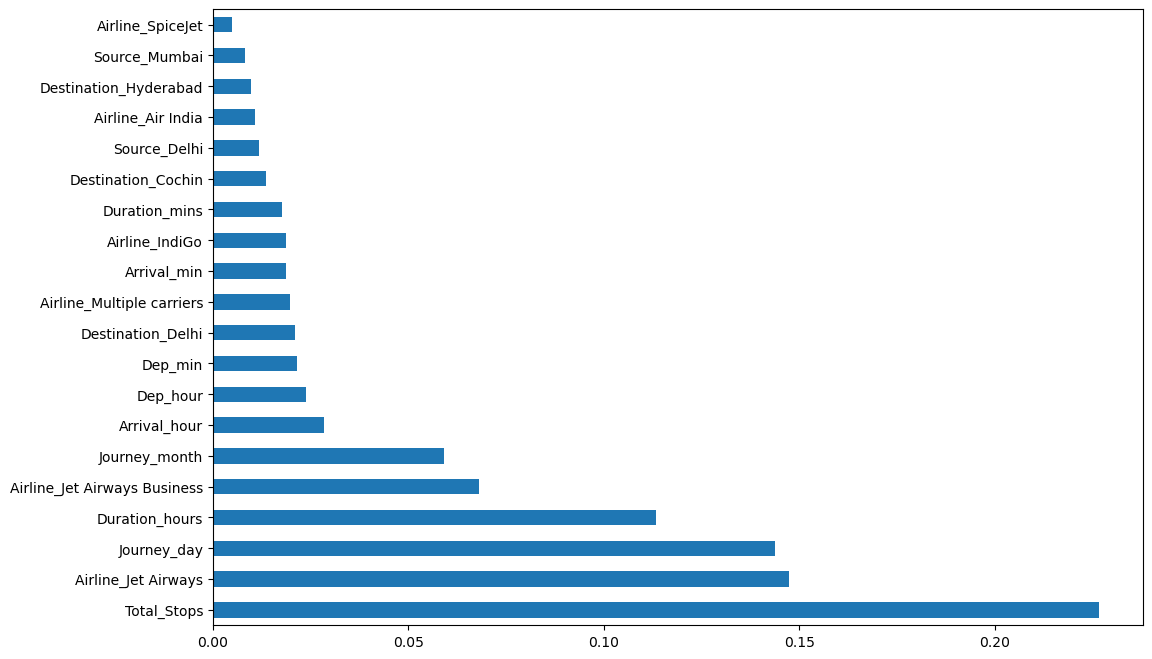

In [32]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# **Fitting model using Random Forest**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [36]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [37]:
prediction = rf_random.predict(X_test)

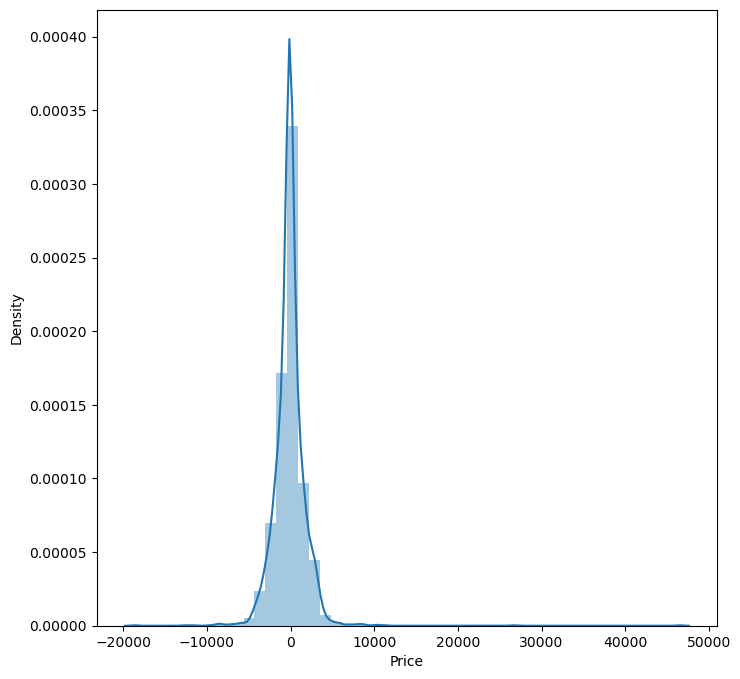

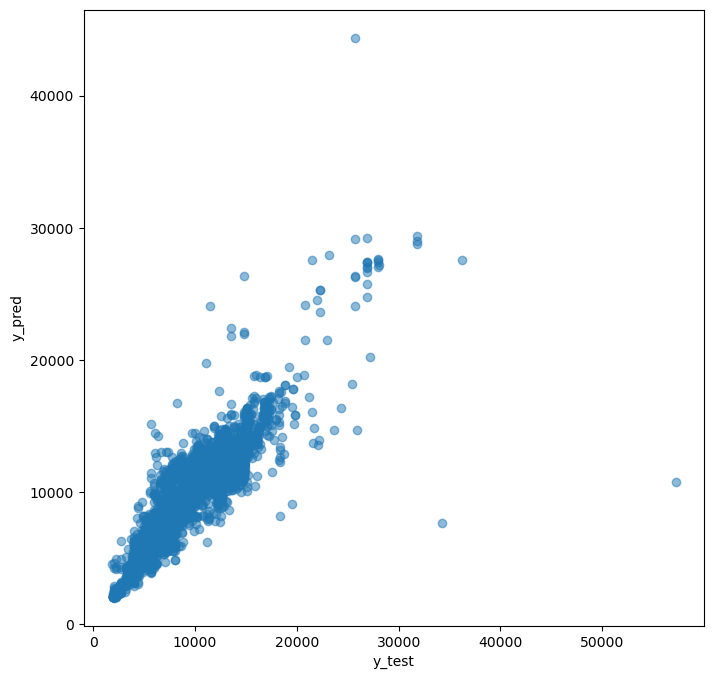

In [38]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [39]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.8111187097137147


# **Saving Model for reuse**

In [40]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)